In [1]:
import sys
sys.path.append('../scripts/')
from robot import * 
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self,init_pose):
        self.pose = init_pose
        
    def motion_update(self,nu,omega,time,noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        # 式(5.12)処理
        noised_nu = nu + ns[0] * math.sqrt(abs(nu) / time) + ns[1] * math.sqrt(abs(omega) / time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu) / time) + ns[3] * math.sqrt(abs(omega) / time)
        self.pose = IdealRobot.state_transition(noised_nu,noised_omega,time,self.pose) # 粒子の移動
        

In [3]:
# 現在地と粒子の数

class Mcl:
    # motion_nosise_stds:標準偏差σ_ab
    def __init__(self,init_pose,num,motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2,v["no"]**2,v["on"]**2,v["oo"]**2 ]) # 与えられた要素を二乗して対角行列へ返す
        self.motion_noise_rate_pdf = multivariate_normal(cov = c)
        
    def motion_update(self,nu,omega,time):
        #print(self.motion_noise_rate_pdf.cov)
        # class Particle のmotion_updateを全粒子に行う
        for p in self.particles: p.motion_update(nu,omega,time,self.motion_noise_rate_pdf)
    
    # 粒子を描画する(位置、姿勢)
    def draw(self,ax,elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] # ベクトルのx成分
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,color = "blue" , alpha = 0.5)) # 粒子の位置と姿勢を登録

In [4]:
class EstimationAgent(Agent):
    def __init__(self,time_interval,nu,omega,estimator):
        super().__init__(nu,omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self,observation = None):
        self.estimator.motion_update(self.prev_nu,self.prev_omega,self.time_interval)# class Mclのmotion_update
        self.prev_nu,self.prev_omega = self.nu,self.omega
        return self.nu,self.omega

    def draw(self,ax,elems):
        self.estimator.draw(ax,elems)
        elems.append(ax.text(0,0,"hoge",fontsize = 10))

In [5]:
initial_pose = np.array([0,0,0]).T
estimator = Mcl(initial_pose,100,motion_noise_stds = {"nn":0.01,"no":0.02,"on":0.03,"oo":0.04})
a = EstimationAgent(0.1,0.2,10.0 / 180 * math.pi,0.1)
estimator.motion_update(0.2,10.0 / 180 * math.pi,0.1)
for p in estimator.particles:
    print(p.pose)


[0.01439321 0.00015543 0.02159615]
[0.0170894  0.00017151 0.02007197]
[1.71655798e-02 3.64206764e-05 4.24344790e-03]
[0.016856   0.00011736 0.01392441]
[2.22453823e-02 7.41125311e-05 6.66315875e-03]
[0.01716017 0.00015968 0.01861016]
[0.01973027 0.00024901 0.02523972]
[0.02229856 0.00016619 0.01490518]
[1.84490567e-02 9.44131978e-05 1.02349270e-02]
[0.02228782 0.00013814 0.01239541]
[0.02429217 0.00037956 0.03124743]
[0.02223656 0.00028097 0.02526987]
[1.93566602e-02 8.23678978e-05 8.51049713e-03]
[0.01668028 0.00020874 0.02502712]
[2.25145114e-02 9.57261086e-05 8.50345184e-03]
[0.02358498 0.00011089 0.00940376]
[0.02443401 0.00025695 0.02103136]
[0.02018687 0.00012045 0.01193319]
[0.02402216 0.00016292 0.01356428]
[0.02324379 0.00021336 0.01835755]
[0.01821382 0.00018577 0.02039765]
[1.71506069e-02 8.48948359e-05 9.89984119e-03]
[0.0265836  0.00020054 0.01508686]
[0.02228275 0.00023689 0.02126131]
[0.01494652 0.00016938 0.02266429]
[0.02092515 0.00010774 0.01029747]
[0.02194742 0.0001

<IPython.core.display.Javascript object>


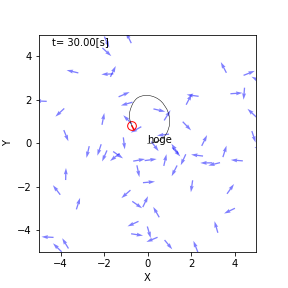

In [7]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30,time_interval)
    
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(initial_pose,100,motion_noise_stds)
    circling = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,estimator)
    r = Robot(initial_pose,sensor = None,agent = circling,color = "red")
    world.append(r)
    
    world.draw()
    
trial({"nn":1,"no":2,"on":3,"oo":4})
# noiseのパラメタがテキトーなので、robotと粒子が乖離してしまう